# Federated Learning for Intrusion Detection 101

<a href="https://colab.research.google.com/github/phdcybersec/teaching/blob/main/tutorials/fl_for_ids_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to this introduction to using federated learning (FL) for intrusion detection!

In this notebook, we'll learn how to build a collaborative intrusion detection system (IDS), using [Tensorflow](https://www.tensorflow.org) and the [Flower](https://flower.dev) framework. In part I., we train a ML model to classify intrusion in network flows. In part II., we try to train the same model on locally collected data. Finally, in part III., we use FL to collaboratively train the model, benefiting from the experience of the others.

> Hey, I'm Leo 👋
> 
> I’m a doctoral researcher at [IMT Atlantique](https://imt-atlantique.fr) and founded by the chair [Cyber CNI](https://cybercni.fr). My research focuses on collaboration in security systems, and how to share data without compromising on security. I study tools like FL for such purposes. 
>
> You can find the sources of this notebook on [Github](https://github.com/phdcybersec/teaching), and more on me on [my website](https://leolavaur.re).

Let's get stated!

## Use case and context

You're in charge experimenting on novel intrusion detection techniques at your organization. Thanks to the effort of your security operation center (SOC), you have access to labelled network flow, with different attack classes. However, as labelling is extremely resource-consuming, you are limited in data quantity.

We will use NSL-KDD, a well known dataset for intrusion detection <a name="ref1"></a>[[1\]](#note1), to represent the labeled data. However, only a tenth of it is produced by your organization. The other 90% come from other similar institutions working on the same task: you do not have access to their data.

Commercial agreements are of no help here. Your hierarchy refuses to share any form of collected data, as it might expose sensitive information. Furthermore, as labeled data has value, the other companies won't share it either. Your goal is to build as collaborative system that you can use with your peers from other organizations to benefit from the experience and training of each other.

## Prerequisites

Before we begin with any actual code, let's make sure that we have everything we need:
- some python packages for ML and data processing;
- the NSL-KDD dataset.

In [191]:
# check if we are running on Google Colab
if "google.colab" in str(get_ipython()):
    !pip install -q flwr[simulation] tensorflow matplotlib pandas numpy sklearn
else:
    # if not, we assume we are running on a local machine were dependencies are already
    # installed; cd to a temporary directory to avoid cluttering the current directory
    
    import os
    try:
        os.mkdir("/tmp/nslkdd")
    except FileExistsError:
        pass
    os.chdir("/tmp/nslkdd")
!curl -Lo nslkdd.zip http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip
!unzip -o -d nslkdd nslkdd.zip && rm nslkdd.zip
    

44545.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 23 6444k   23 1536k    0     0   382k      0  0:00:16  0:00:04  0:00:12  382k^C


44555.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Archive:  nslkdd.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of nslkdd.zip or
        nslkdd.zip.zip, and cannot find nslkdd.zip.ZIP, period.



Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [ ]:
import os
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flwr.common import Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from numpy.typing import ArrayLike, NDArray

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

# Make keras available in this namespace (for IntelliSense)
keras = tf.keras

To run this notebook more confortably, consider using a machine with a GPU. On Google Colab, go to `Runtime > Change runtime type > Hardware acclerator: GPU > Save`.

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


Finally, we will set the seed for our PRNGs (pseudo-random number generators), thus making sure that our experiments will always produce the same results. Keras provides a nice API that does exactly this. We also enable Tensorflow's "determinism", which avoids concurrent calls to return theiur values in a different order. Without it, ML computations will vary between runs, even with the seed <a name="ref3"></a>[[3\]](#note3).

In [ ]:
SEED = 1138

tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

## Part I. Reviewing the baseline

In this section, we build a deep learning (DL) model on NSL-KDD, due to their performance.

We start with a *perfect* scenario where we have access to the entire dataset at once. It would mean that, either your organization did a massive effort in terms of data collection and labeling, or you collected datasets from others.

This will be the baseline that we'll try to approach thanks to FL.


### Step 0: Data loading and preprocessing

First, we need to load and preprocess our data. NSL-KDD is provided as `.txt` files, but are actually CSV without the corresponding column names. We use `pandas` to load the CSV files as dataframes that we can then manipulate.

In [ ]:
# column names:
# https://github.com/kahramankostas/NSL-KDD-binary-classification-with-Transformer#reading-csv-files
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
    "dst_host_srv_rerror_rate", "label", "difficulty"
]

# load datasets
train_df = pd.read_csv("./nslkdd/KDDTrain+.txt", names=c_names)
test_df = pd.read_csv("./nslkdd/KDDTest+.txt", names=c_names)

The analyzed dataset must be prepared to be processable by our neural network.
Usually, NNs require some characteristics:
- *Only numerical values.* Classes and text-based attributes must be transformed
  to numerical values. This can be easilly done with one-hot encoding as
  implemented in `pandas.get_dummies` or `keras.utils.to_categoretical`, except
  the latter need values to be already numeric classes.
- *Normalized values*. To avoid having one value taking predecence over the
  others, values must be normalized over a close range. Since NNs also perform
  better with small values, normalization is usually done over the `[0..1]`
  range.

In [ ]:
# extract the labels for the outputs (will serve as metadata)
m_train = train_df["label"]
m_test = test_df["label"]

# drop labels for input, and difficulty
train_df = train_df.drop(columns=['label', 'difficulty'])
test_df = test_df.drop(columns=['label', 'difficulty'])

# convert classes to numerical values
X_train = pd.get_dummies(train_df)
X_test = pd.get_dummies(test_df)

# reindex the testing dataset so its columns match the training columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# normalize input dataframes
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

print("Number of features:", len(X_train.columns))
print("Length of training set:", len(X_train))
print("Length of testing set:", len(X_test))
print(f"Label distribution in testing set:\n{m_test.value_counts()}")

Number of features: 122
Length of training set: 125973
Length of testing set: 22544
Label distribution in testing set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm              2
phf              

In [ ]:
ATTACK_LABELS = m_train.unique()[m_train.unique() != 'normal']
print(f"Attack labels: {ATTACK_LABELS}")

Attack labels: ['neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap' 'satan'
 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop' 'rootkit'
 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land' 'loadmodule' 'spy'
 'perl']


We will focus on binary classification in this demonstration. Thus, we need to map the current labels to two classes: either benign or malicious. Since the ML model will only work with numerical values, benign becomes `0` and malicious `1`. 

In [ ]:
# apply one-hot encoding to outputs; keep only normal vs abnormal
y_train = m_train.apply(lambda x: False if x == 'normal' else True)
y_test = m_test.apply(lambda x: False if x == 'normal' else True)

#y_train = keras.utils.to_categorical(y_train)
#y_test = keras.utils.to_categorical(y_test)
y_train = pd.get_dummies(y_train, prefix='Malicious')
y_test = pd.get_dummies(y_test, prefix='Malicious')

In [ ]:
y_test.value_counts()

Malicious_False  Malicious_True
0                1                 12833
1                0                  9711
dtype: int64

### Step 1: Choosing an deep ML model

A lot of ML algorithms can be applied to intrusion detection: support vector machines (SVM), random forests (RF), Naive Bayes (NB), or Logistic Regression for instance. The literature started to study neural networks (NN) as an alternative. They represent significant advantages:
- NNs can model complex behaviors, allowing better characterization of security events.
- When using the correct architecture, NNs do not need extensive feature extraction beforehand, as irrelevant features will not influence the output of the model.
- They allow "easy" learning over large quantities of data, since less processing is required.

Due to their over-representation in the litterature, we will focus on DL for this demonstration. However, FL is not restricted to DL, and other types of architectures can be used, as long as their parameters can be shared and aggregated. We start with a multi-layer perceptron (MLP), but you can use more advanced Keras models if you want.

#### Creating a DL model with Keras

Keras is a Tensorflow library for deep learning. Is is geared toward usability and "friendlyness", which makes it perfect for research applications. Keras exposes human-readable APIs that can be used to design, train, and evaluate, all kinds of neural networks.

Let's start by laying out our model's architecture. Our dataset has 122 features, and we want to classify it into two classes. We will use a simple MLP with two hidden layers, each with 32 neurons. The output layer will have a single neuron, with a sigmoid activation function. We use the `relu` activation function for the hidden layers, as it is the most common one. We use the `adam` optimizer, which is a good default choice for most problems. We use the `binary_crossentropy` loss function, as we are performing a binary classification. 

In [ ]:
n_features = X_train.shape[1]
print(n_features)

def create_model() -> keras.Model:
    model = keras.Sequential()
    model.add(keras.layers.Dense(32, activation='relu', input_shape=(n_features,)))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


model = create_model()
model.summary()

122
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 32)                3936      
                                                                 
 dense_34 (Dense)            (None, 32)                1056      
                                                                 
 dense_35 (Dense)            (None, 2)                 66        
                                                                 
Total params: 5,058
Trainable params: 5,058
Non-trainable params: 0
_________________________________________________________________


### Step 2: Training the model

Training a model means finding the best parameters for it, so that it can correctly classify the
data. This is done by minimizing a loss function, which is a measure of how well the model performs
on the training data. The loss function is computed on the training data, and the model is updated
to minimize it. This process is repeated until the loss function converges to a local minimum.

We will use the `fit` method of the Keras model to train it over 10 epochs. We will also use a batch
size of 32, which means that the model will be updated after each batch of 32 samples. This is a
good default value, but you can experiment with it to see if it improves the results.

When doing supervised learning, we often keep a validation set to evaluate the model's performance
during training. This allows us to see if the model is overfitting, and to stop the training process
before it does. We will use 10% of the training data as a validation set.

In [ ]:
bl_hist = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.1)


Epoch 1/10
3543/3543 [==============================] - 12s 3ms/step - loss: 0.0582 - accuracy: 0.9805 - val_loss: 0.0360 - val_accuracy: 0.9855
Epoch 2/10
3543/3543 [==============================] - 10s 3ms/step - loss: 0.0312 - accuracy: 0.9888 - val_loss: 0.0279 - val_accuracy: 0.9888
Epoch 3/10
3543/3543 [==============================] - 10s 3ms/step - loss: 0.0245 - accuracy: 0.9914 - val_loss: 0.0232 - val_accuracy: 0.9910
Epoch 4/10
3543/3543 [==============================] - 10s 3ms/step - loss: 0.0195 - accuracy: 0.9933 - val_loss: 0.0170 - val_accuracy: 0.9950
Epoch 5/10
3543/3543 [==============================] - 10s 3ms/step - loss: 0.0168 - accuracy: 0.9941 - val_loss: 0.0162 - val_accuracy: 0.9947
Epoch 6/10
3543/3543 [==============================] - 10s 3ms/step - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0.0236 - val_accuracy: 0.9897
Epoch 7/10
3543/3543 [==============================] - 10s 3ms/step - loss: 0.0140 - accuracy: 0.9949 - val_loss: 0.0164 - val_ac

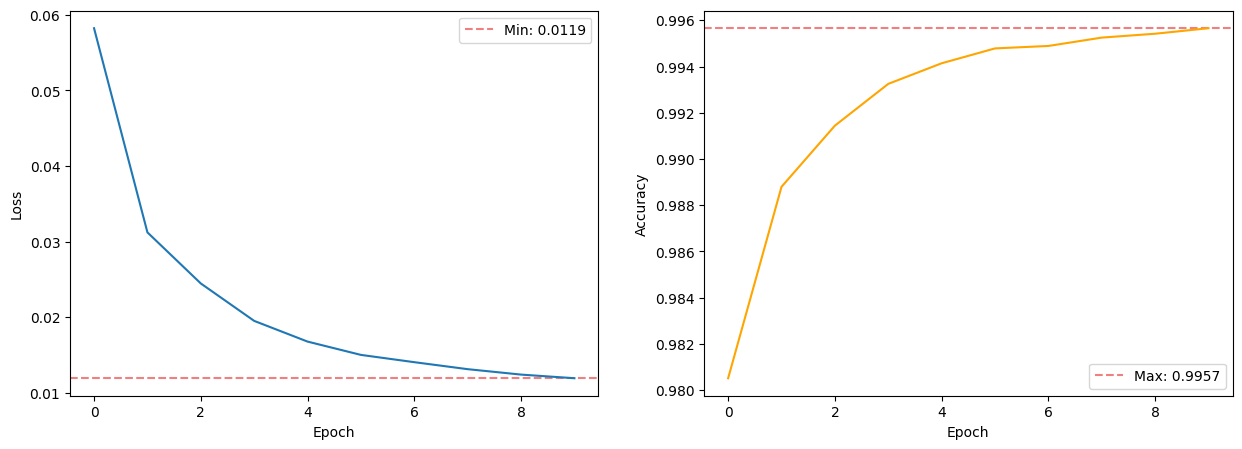

In [ ]:
# plot training history, loss and accuracy side by side
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_min = np.min(bl_hist.history['loss'])
ax1.axhline(y=_min, label=f"Min: {_min:.4f}", linestyle='--', color='lightcoral')
ax1.plot(bl_hist.history['loss'])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
_max = np.max(bl_hist.history['accuracy'])
ax2.axhline(y=_max, label=f"Max: {_max:.4f}", linestyle='--', color='lightcoral')
ax2.plot(bl_hist.history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

### Step 3: Analyzing the results

Once the model is trained, we can evaluate its performance on the test set. We will use the
`evaluate` method of the Keras model to compute a set of metrics, including the loss function and the accuracy. 

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss}")
print(f"Test accuracy: {acc}")



Test loss: 1.8433220386505127
Test accuracy: 0.7964868545532227


We can also use the `predict` method to get the model's inferences on the test set. We can then plot
a confusion matrix to see how the models characterizes the different classes. In a binary
classification, the confusion matrix is a 2x2 matrix, with the following values:
- true positives (TP): number of malicious samples that were correctly classified
- false positives (FP): number of malicious samples that were missed
- true negatives (TN): number of benign samples that were correctly classified
- false negatives (FN): number of benign samples that were incorrectly classified as malicious

These indicators are used to compute metrics such as precision, recall, and F1-score.

In [ ]:
inferences = model.predict(X_test)
print(inferences.shape)
print(f"First 10 predictions:\n{inferences[:10]}")

705/705 [==============================] - 1s 1ms/step
(22544, 2)
First 10 predictions:
[[5.2579097e-21 1.0000000e+00]
 [1.6332500e-19 1.0000000e+00]
 [9.9993229e-01 6.7708883e-05]
 [3.7903428e-07 9.9999964e-01]
 [9.6445316e-01 3.5546884e-02]
 [9.9999857e-01 1.4614752e-06]
 [6.9132477e-01 3.0867523e-01]
 [9.9997652e-01 2.3494384e-05]
 [1.0000000e+00 1.0012818e-09]
 [9.9997818e-01 2.1779866e-05]]


While trained to approach `1` or `0`, the models produces inferences as a tuple of probabilities,
one for each class. We can use the `argmax` function to get the class with the highest probability. 

True Negatives: 9418
False Positives: 293
False Negatives: 4295
True Positives: 8538


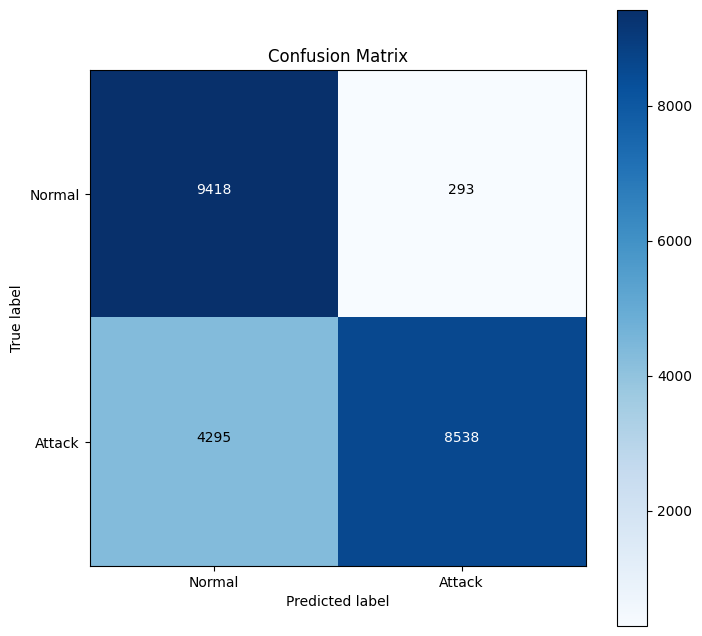

In [ ]:
# convert to binary
y_pred = np.argmax(np.round(inferences), axis=1)
y_true = np.argmax(y_test.to_numpy(), axis=1)

# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.show()

plot_cm(cm)


The confusion matrix shows a high number of false positives, which is a common problem in intrusion
detection. This means that the model have a tendency to incorrectly classify benign samples as
malicious. However, we can establish baselines for the performance of our model, and compare it with
the results of local learning and FL.

In [ ]:
bl_acc = (tn + tp) / (tn + fp + fn + tp)
bl_prec = tp / (tp + fp)
bl_rec = tp / (tp + fn)
bl_f1 = 2 * bl_prec * bl_rec / (bl_prec + bl_rec)
bl_miss = fn / (fn + tp)

print(f"Baseline Accuracy: {bl_acc:.4f}")
print(f"Baseline Precision: {bl_prec:.4f}")
print(f"Baseline Recall: {bl_rec:.4f}")
print(f"Baseline F1: {bl_f1:.4f}")
print(f"Baseline Miss Rate: {bl_miss:.4f}")


Baseline Accuracy: 0.7965
Baseline Precision: 0.9668
Baseline Recall: 0.6653
Baseline F1: 0.7882
Baseline Miss Rate: 0.3347


Before continuing, let's write an evaluation function that will allow us to easily evaluate our
future models. Let's also save the model's weights, so that we can reuse them later.

In [ ]:
from typing import Dict
from numpy.typing import NDArray


def eval_model(model, X, y) -> Tuple[NDArray, Dict[str, float | int]]:
    """evaluate the model on the given data and return the confusion matrix and metrics"""

    inferences = model.predict(X)
    y_pred = np.argmax(np.round(inferences), axis=1)
    y_true = np.argmax(y_test.to_numpy(), axis=1)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    return cm, {
        'accuracy': (tn + tp) / (tn + fp + fn + tp),
        'precision': tp / (tp + fp),
        'recall': tp / (tp + fn),
        'f1': 2 * tp / (2 * tp + fp + fn),
        'miss_rate': fn / (fn + tp)
    }

# save weights in a variable
bl_weights = model.get_weights()


## Part II. Training on local data

After having seen the performance of a model trained on the entire dataset, we will now train it on
a subset of the data, as if your organization only had access its local data. We will then compare
the results with the baseline.

We simulate having multiple datasets from multiple organizations (also called the "cross-silo"
setting in federated learning) by splitting NSL-KDD Train+ set into multiple partitions. Each
partition will represent one organization. To highlight the knowledge transfer between
organizations, we will randomly remove attack classes from each partition. This will simulate 
organizations that have different expertise and knowledge about the attacks they are facing.

### Step 0: Splitting data amongst clients

In [ ]:
import math
from sklearn.utils import shuffle


NUM_CLIENTS = 10
NUM_REMOVED_CLASSES = 6

# shuffle the data
X_train, y_train, m_train = shuffle(X_train, y_train, m_train)

# split the data into NUM_CLIENTS parts
partition_size = math.floor(len(X_train) / NUM_CLIENTS)
partitions = []

for i in range(NUM_CLIENTS):
    idx_from, idx_to = i * partition_size, (i + 1) * partition_size

    X_part = X_train[idx_from:idx_to]
    y_part = y_train[idx_from:idx_to]
    m_part = m_train[idx_from:idx_to]

    # randomly remove NUM_REMOVED_CLASSES from each partition
    _rm_classes = np.random.choice(ATTACK_LABELS, NUM_REMOVED_CLASSES, replace=False)

    X_part = X_part[m_part.isin(_rm_classes) == False]
    y_part = y_part[m_part.isin(_rm_classes) == False]
    m_part = m_part[m_part.isin(_rm_classes) == False]
    lacks = _rm_classes

    partitions.append((X_part, y_part, m_part, lacks))



To observe the partition we made, we can plot some of them.

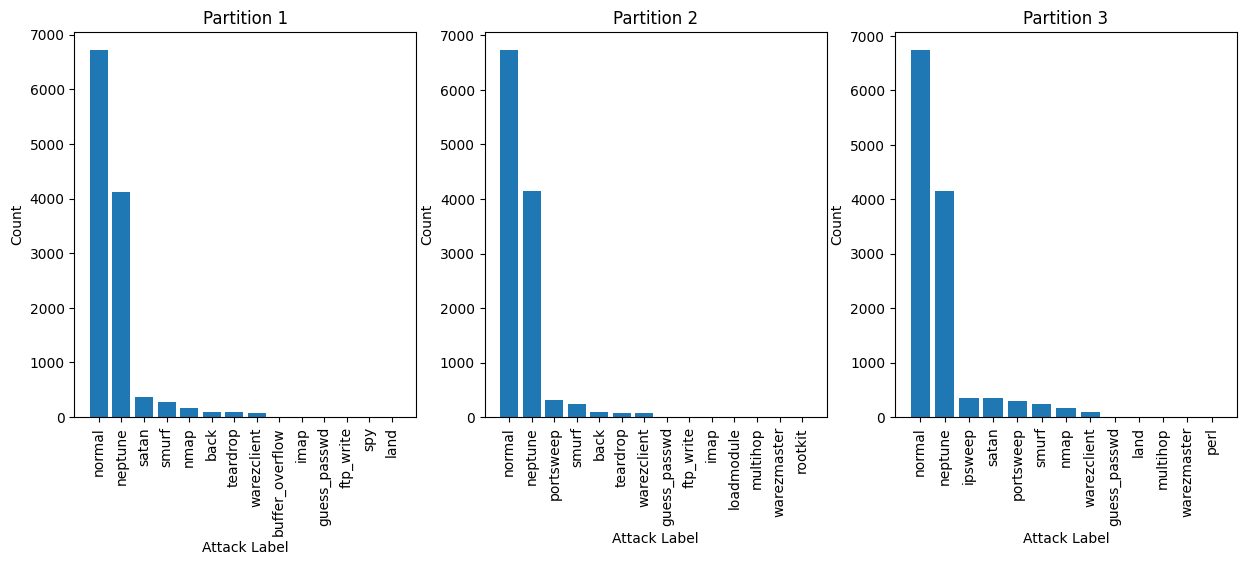

In [ ]:

# plot the distribution of 3 partitions
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Partition 1")
ax1.set_ylabel("Count")
ax1.set_xlabel("Attack Label")
ax1.tick_params(axis='x', rotation=90)
ax1.bar(partitions[0][2].value_counts().index, partitions[0][2].value_counts())
ax2.set_title("Partition 2")
ax2.set_ylabel("Count")
ax2.set_xlabel("Attack Label")
ax2.tick_params(axis='x', rotation=90)
ax2.bar(partitions[1][2].value_counts().index, partitions[1][2].value_counts())
ax3.set_title("Partition 3")
ax3.set_ylabel("Count")
ax3.set_xlabel("Attack Label")
ax3.tick_params(axis='x', rotation=90)
ax3.bar(partitions[2][2].value_counts().index, partitions[2][2].value_counts())
plt.show()


### Step 1: Testing the local models

Lets try our model on local data. You can try any partition and observe the results.

In [ ]:
model = create_model()

part = partitions[2]

hist = model.fit(part[0], part[1], epochs=10, batch_size=32, verbose=1, validation_split=0.1)



Epoch 1/10
349/349 [==============================] - 2s 4ms/step - loss: 0.1234 - accuracy: 0.9690 - val_loss: 0.0375 - val_accuracy: 0.9839
Epoch 2/10
349/349 [==============================] - 1s 3ms/step - loss: 0.0370 - accuracy: 0.9854 - val_loss: 0.0258 - val_accuracy: 0.9935
Epoch 3/10
349/349 [==============================] - 1s 3ms/step - loss: 0.0305 - accuracy: 0.9885 - val_loss: 0.0229 - val_accuracy: 0.9935
Epoch 4/10
349/349 [==============================] - 1s 3ms/step - loss: 0.0268 - accuracy: 0.9885 - val_loss: 0.0249 - val_accuracy: 0.9927
Epoch 5/10
349/349 [==============================] - 1s 3ms/step - loss: 0.0245 - accuracy: 0.9909 - val_loss: 0.0220 - val_accuracy: 0.9944
Epoch 6/10
349/349 [==============================] - 1s 3ms/step - loss: 0.0226 - accuracy: 0.9910 - val_loss: 0.0215 - val_accuracy: 0.9911
Epoch 7/10
349/349 [==============================] - 1s 3ms/step - loss: 0.0212 - accuracy: 0.9912 - val_loss: 0.0202 - val_accuracy: 0.9944
Epoch 

705/705 [==============================] - 1s 1ms/step


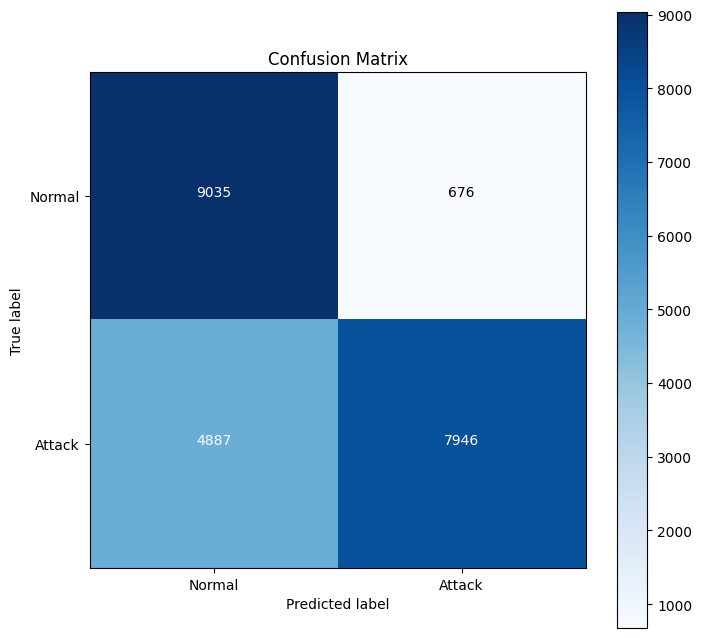

In [ ]:
cm, metrics = eval_model(model, X_test, y_test)
plot_cm(cm)

We can already see a slight increase in both false positives and false negatives. While some
*behaviors* can overlap between attack classes, such as bruteforce attacks and DoS attacks, the lack
of some attack samples will prevent it to proporly learn them. 

We can also compare the results with the baseline we trained earlier. 

In [ ]:
# print model metrics against the baseline
print(f"Accuracy: {metrics['accuracy']:.4f} (Baseline: {bl_acc:.4f}, % Diff: {100 * (metrics['accuracy'] - bl_acc) / bl_acc:.2f})")
print(f"Precision: {metrics['precision']:.4f} (Baseline: {bl_prec:.4f}, % Diff: {100 * (metrics['precision'] - bl_prec) / bl_prec:.2f})")
print(f"Recall: {metrics['recall']:.4f} (Baseline: {bl_rec:.4f}, % Diff: {100 * (metrics['recall'] - bl_rec) / bl_rec:.2f})")
print(f"F1: {metrics['f1']:.4f} (Baseline: {bl_f1:.4f}, % Diff: {100 * (metrics['f1'] - bl_f1) / bl_f1:.2f})")
print(f"Miss Rate: {metrics['miss_rate']:.4f} (Baseline: {bl_miss:.4f}, % Diff: {100 * (metrics['miss_rate'] - bl_miss) / bl_miss:.2f})")


Accuracy: 0.7532 (Baseline: 0.7965, % Diff: -5.43)
Precision: 0.9216 (Baseline: 0.9668, % Diff: -4.68)
Recall: 0.6192 (Baseline: 0.6653, % Diff: -6.93)
F1: 0.7407 (Baseline: 0.7882, % Diff: -6.03)
Miss Rate: 0.3808 (Baseline: 0.3347, % Diff: 13.78)


The results are significantly worse than the baseline. Let's focus on the attacks that were removed
and see how the model was able to generalize.

In [190]:
inferences = model.predict(X_test)

y_pred = np.argmax(np.round(inferences), axis=1)

# remember: part[3] contains a list of the removed classes
y_pred_lack = y_pred[m_test.isin(part[3])]

print(f"Percentage of removed attacks detected (Local): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

# try with the baseline model
model.set_weights(bl_weights)

inferences = model.predict(X_test)

y_pred = np.argmax(np.round(inferences), axis=1)
y_pred_lack = y_pred[m_test.isin(part[3])]
print(f"Percentage of removed attacks detected (Baseline): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")


705/705 [==============================] - 1s 1ms/step
Percentage of removed attacks detected: 10.51%


NameError: name 'bl_weights' is not defined

## Part III. Collaborative Learning with FL

### Step 0: Introduction to FL and Flower

### Step 1: Creating clients

### Step 2: Setting up an FL server

### Step 3: Federating the learning!

### Step 4: Analyzing the results

We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original CIFAR-10 dataset into multiple partitions. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (so the data is naturally partitioned).

Each organization will act as a client in the federated learning system. So having ten organizations participate in a federation means having ten clients connected to the federated learning server:


In [186]:
NUM_CLIENTS = 10


Let's now load the CIFAR-10 training and test set, partition them into ten smaller datasets (each split into training and validation set), and wrap the resulting partitions by creating a PyTorch `DataLoader` for each of them:

In [187]:
BATCH_SIZE = 32


def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

NameError: name 'transforms' is not defined

We now have a list of ten training sets and ten validation sets (`trainloaders` and `valloaders`) representing the data of ten different organizations. Each `trainloader`/`valloader` pair contains 4500 training examples and 500 validation examples. There's also a single `testloader` (we did not split the test set). Again, this is only necessary for building research or educational systems, actual federated learning systems have their data naturally distributed across multiple partitions.

Let's take a look at the first batch of images and labels in the first training set (i.e., `trainloaders[0]`) before we move on:

## Final remarks

Congratulations, you just trained a convolutional neural network, federated over 10 clients! With that, you understand the basics of federated learning with Flower. The same approach you've seen can be used with other machine learning frameworks (not just PyTorch) and tasks (not just CIFAR-10 images classification), for example NLP with Hugging Face Transformers or speech with SpeechBrain.

In the next notebook, we're going to cover some more advanced concepts. Want to customize your strategy? Initialize parameters on the server side? Or evaluate the aggregated model on the server side? We'll cover all this and more in the next tutorial.

## Next steps

Before you continue, make sure to join the Flower community on Slack: [Join Slack](https://flower.dev/join-slack/)

There's a dedicated `#questions` channel if you need help, but we'd also love to hear who you are in `#introductions`!

The [Flower Federated Learning Tutorial - Part 2](https://flower.dev/docs/tutorial/Flower-2-Strategies-in-FL-PyTorch.html) goes into more depth about strategies and all the advanced things you can build with them.

## Sources

<a name="note1"></a>[[1\]](#ref1) M. Tavallaee, E. Bagheri, W. Lu, and A. A. Ghorbani, “A detailed analysis of the KDD CUP 99 data set,” in 2009 IEEE Symposium on Computational Intelligence for Security and Defense Applications, Jul. 2009

<a name="note2"></a>[[2\]](#ref2) **TODO**

<a name="note3"></a>[[3\]](#ref3) https://www.tensorflow.org/versions/r2.8/api_docs/python/tf/config/experimental/enable_op_determinism


## Credits

This tutorial is heavily based on the Flower team's tutorials and documentation. You can find the links to some of them below:

- [An Introduction to Federated Learning](https://github.com/adap/flower/blob/main/doc/source/tutorial/Flower-1-Intro-to-FL-PyTorch.ipynb)
- [Flower Quickstart (Simulation with TensorFlow/Keras)](https://github.com/adap/flower/blob/main/examples/simulation_tensorflow/sim.ipynb)



---



---



### Training the model

We now have all the basic building blocks we need: a dataset, a model, a training function, and a test function. Let's put them together to train the model on the dataset of one of our organizations (`trainloaders[0]`). This simulates the reality of most machine learning projects today: each organization has their own data and trains models only on this internal data: 

In [ ]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

: 

Training the simple CNN on our CIFAR-10 split for 5 epochs should result in a test set accuracy of about 41%, which is not good, but at the same time, it doesn't really matter for the purposes of this tutorial. The intent was just to show a simplistic centralized training pipeline that sets the stage for what comes next - federated learning!

## Step 2: Federated Learning with Flower

Step 1 demonstrated a simple centralized training pipeline. All data was in one place (i.e., a single `trainloader` and a single `valloader`). Next, we'll simulate a situation where we have multiple datasets in multiple organizations and where we train a model over these organizations using federated learning.

### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

We need two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: `set_parameters` and `get_parameters`. The following two functions do just that for the PyTorch model above.

The details of how this works are not really important here (feel free to consult the PyTorch documentation if you want to learn more). In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which Flower knows how to serialize/deserialize):

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

: 

### Implementing a Flower client

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

: 

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Using the Virtual Client Engine

In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

: 

### Starting the training

We now have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`. 

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - starts the simulation:

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

: 

### Behind the scenes

So how does this work? How does Flower execute this simulation?

When we call `start_simulation`, we tell Flower that there are 10 clients (`num_clients=10`). Flower then goes ahead an asks the `FedAvg` strategy to select clients. `FedAvg` knows that it should select 100% of the available clients (`fraction_fit=1.0`), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

Flower then asks the selected 10 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (*FedAvg*) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

### Where's the accuracy?

You may have noticed that all metrics except for `losses_distributed` are empty. Where did the `{"accuracy": float(accuracy)}` go?

Flower can automatically aggregate losses returned by individual clients, but it cannot do the same for metrics in the generic metrics dictionary (the one with the `accuracy` key). Metrics dictionaries can contain very different kinds of metrics and even key/value pairs that are not metrics at all, so the framework does not (and can not) know how to handle these automatically.

As users, we need to tell the framework how to handle/aggregate these custom metrics, and we do so by passing metric aggregation functions to the strategy. The strategy will then call these functions whenever it receives fit or evaluate metrics from clients. The two possible functions are `fit_metrics_aggregation_fn` and `evaluate_metrics_aggregation_fn`.

Let's create a simple weighted averaging function to aggregate the `accuracy` metric we return from `evaluate`:

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

: 

The only thing left to do is to tell the strategy to call this function whenever it receives evaluation metric dictionaries from the clients:

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

: 

We now have a full system that performs federated training and federated evaluation. It uses the `weighted_average` function to aggregate custom evaluation metrics and calculates a single `accuracy` metric across all clients on the server side.

The other two categories of metrics (`losses_centralized` and `metrics_centralized`) are still empty because they only apply when centralized evaluation is being used. Part two of the Flower tutorial will cover centralized evaluation.